# Amazon Textract - Receipts Demo

The purpose of this notebook is to show Data Scientists how to extract structured data from documents using Amazon Textract, and then how to explore that data for further insights using Part of Speech Tagging (POS), Named Entity Recognition (NER), Word Co-occurrence (manual), and Word Embeddings using Amazon SageMaker's Built in Blazing Text Algorithm.

Amazon Textract makes it really easy to extract structured text from documents like receipts, but <insert more here>. In the real world, we need to do more than just extract text. In this notebook, we'll use a set of receipt images as a sample dataset, and you'll see how to get started extracting structured data from the receipts, and then how to do further data science work to explore and enrich the dataset for further insights. 

By the end of this notebook, you should have learnt how to:

- How to use Amazon Textract to ingest multiple images and obtain the results from the API
- How to interpret the Amazon Textract results
- How to use the Amazon Textract results in order to perform data exploration
- How to enrich raw OCR data with Entity Tags
- How to perform simple Feature Engineering to reduce large datasets
- How to use Amazon SageMaker to build Word Embeddings (Vector Space Representations) of your data

Files used: 

- ```util.py``` -  contains some methods which perform mundane functions.
- ```stopwords_custom.txt``` - contains custom stop words, specifically generated for the re

### **Contents:**
- Part 0 - Housekeeping
- Part 1 - Data Download and Amazon Textract Enrichment
- Part 2 - Data Enrichment (NLTK/SPACY) and Exploration
    - 2.1 POS and NER
    - 2.2 Data Analysis
    - 2.3 Term Co-occurrence
    - 2.4 Feature Analysis
    - 2.5 Word Embeddings
- Part 3 - Exporting Outputs

## Part 0. Housekeeping



### General Imports

These are the libraries which we will require in order to complete different types of operations.

Just a quick note, you may need to use ```nltk.download()``` in order to download the correct libraries and additional packages required to perform text tagging

In [1]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import pandas as pd
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from matplotlib import pylab
import nltk 
import spacy
import en_core_web_lg
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer 
import string
import pickle
from nltk.corpus import stopwords 
from itertools import combinations 
import operator
from io import BytesIO
import tarfile
import seaborn as sns
from src import utils

### Constant Set-up
Configure all global constants here, these are variables which will remain constant throughout the execution of the notebook.

In [2]:
configs = {
    'aws_region' :  'us-east-1',
    'bucket_name': 'aws-demo-receipts',
    'prefix' : 'preprocessed_reviews', #only use this if you want to have your files in a folder 
    'dataset_path_s3' : 'receipts_data/',
    'training_data_prefix_s3' : 'training_data/',
    'output_data_s3' : 'output_data/',
    'dataset_zipped_filename': 'large-receipt-image-dataset-SRD.zip',
    'dataset_zipped_path':'data_zipped/',
    'tmp_folder':'tmp/',
    'stopwords_custom': 'stopwords_custom.txt' 
}

global_vars = {}

### Environment Setup

Setting up the environment involves ensuring all the corret session and IAM roles are configured. We also need to ensure the correct region and bucket is made available.

In [3]:
global_vars = utils.setup_env(configs, global_vars)

Bucket already exists


In [4]:
def setup_nlp(configs, global_vars):
    
    nlp = en_core_web_lg.load()
    global_vars['nlp'] = nlp
    stop_words = []
    with open(configs['stopwords_custom'], 'r') as file:
        for line in file:
            stop_words.append(line.strip())
    global_vars['stop_words'] = stop_words
    return global_vars

global_vars = setup_nlp(configs, global_vars)

## Part 1. Download Data and Perform OCR using Amazon Textract

Here we are goin to download the data to our bucket if it does not already exist. This dataset is a pre-compiled dataset of Receipt Images, with no labels

The following create_dataset method will first download the Zip of the data, and then unpack it to the bucket named in the global constants



In [4]:
def create_dataset(configs, global_vars):
    
    dataset_key = configs['dataset_path_s3']
    s3_bucket = global_vars['s3_bucket']
    objs = list(s3_bucket.objects.filter(Prefix=dataset_key))

    if len(objs) > 0 and objs[0].key == configs['dataset_zipped_filename']:
        exists = True
        print('{} Already Exists, No need to copy to S3 or Unzip'.format(dataset_key) )
    else:
        exists = False
    
    if not exists:
        
        data_path = configs['dataset_zipped_path'] + configs['dataset_zipped_filename']
        data_file_s3 = configs['dataset_path_s3'] + configs['dataset_zipped_filename']
        s3_bucket.upload_file(data_path, data_file_s3)

        s3 = boto3.client('s3', use_ssl=False)
        Key_unzip = configs['dataset_path_s3']

    
        s3_resource = boto3.resource('s3')
        #Now create zip object one by one, this below is for 1st file in file_list
        zip_obj = s3_resource.Object(bucket_name=bucket_name, key=data_file_s3)
        
        print('Unpacking {}\n'.format(data_file_s3))
        print (zip_obj)
        buffer = BytesIO(zip_obj.get()["Body"].read())
        z = zipfile.ZipFile(buffer)
        for filename in z.namelist():
            file_info = z.getinfo(filename)
            s3_resource.meta.client.upload_fileobj(
                z.open(filename),
                Bucket=bucket_name,
                Key=Key_unzip + f'{filename}')
             
# create_dataset(bucket_name, s3_bucket)

### OCR Processing with Amazon Textract

The first step in processing the data will be to use the Amazon Textract service to convert the text in the receipt images into a form we can process (strings). In order to do this, we will use the ```detect_document_text``` method available via the Textract API. Documentation can be found [here](https://textract.readthedocs.io/en/stable/). Prior to sending the data to the API, we first need to convert the images to their Byte array representation (a matrix of bytes), which will then be consumed by the Textract ```detect_document_text``` API endpoint.

In the ```process_receipts_using_textract``` method below, we're using the Textract, in sycronous mode, with files which are locally downloaded from the S3 location, however, there is the option to use Textract Asyncronously, with files stored in S3. For more information on this, check the ```StartDocumentTextDetection``` [documentation](https://docs.aws.amazon.com/textract/latest/dg/API_StartDocumentTextDetection.html).

In [ ]:
def process_receipts_using_textract(configs, global_vars, show_image = False):
    
    #first download a temp document
    tmp_folder = configs['tmp_folder']
    try:
        os.mkdir(tmp_folder)
    except:
        pass
    
    s3_bucket = global_vars['s3_bucket']
    s3 = global_vars['s3']
    
    s3_path = configs['dataset_path_s3']
    objs = list(s3_bucket.objects.filter(Prefix=s3_path))
    
    files_data = {}
    for entry in objs:
        print(entry.key)
        file_data = []
        if 'jpg' in entry.key:
            local_path = tmp_folder + 'tmp.jpg'
            s3.Bucket(configs['bucket_name']).download_file(str(entry.key), local_path)  
            
            with open(local_path, 'rb') as document:
                imageBytes = bytearray(document.read())
            
            #this is where we call Amazon Textract!
            response = global_vars['textract'].detect_document_text(Document={'Bytes': imageBytes})
            
            if show_image:
                raw_img = mpimg.imread(local_path)
                height, width, depth = raw_img.shape
                dpi = 80
                figsize = width / float(dpi), height / float(dpi)
                plt.figure(figsize = figsize)
                plt.imshow(raw_img, aspect='auto')

            files_data[entry.key] =  response
            
    return files_data

 
textract_data = process_receipts_using_textract(configs, global_vars)

### Useful if you want to resume a session if the kernal dies

In [5]:
textract_data = utils.load_or_save_record_meta_data('', 'load')

## Part 2. Dataset Enrichment and Exploration

In this section, we're going to be exploring different analytical approaches to interpretting the receipt data. This is an important part of any data science driven experiment, as the exploration (and through the iterations of exploration), will help us derive the most useful insights for a given use case.

In [6]:
utils.inspect_dataset(textract_data)

Total Records 200


### 2.1 Process Data

Using Textract's response, we look at each word in our data, and store it with it's confidence scores. Then a series of data enrichment processes take place.

Note, we use a filtering approach to ensure that we are not introducing random stop words..

#### Enriching the Textract Results

The Following methods will be used to enrich each of the records with additional information.

We're going to use two libraries to perform our enrichment, ```NLTK```, and ```Spacy```.

#### Part of Speech Tagging (POS)

In the world of Natural Language Processing (NLP), the most basic models are based on Bag of Words. But such models fail to capture the syntactic relations between words. ... POS tagging is the process of marking up a word in a corpus to a corresponding part of a speech tag, based on its context and definition.

For Part of Speak Tagging, we're using NLTK. More details can be found here:

https://www.nltk.org/api/nltk.tag.html

The tags which NLTK uses are as follows:

 - CD - cardinal numbers
 - AT -Articles
 - JJ - Adjectives
 - NN Nouns
 - NNS - Plural Nouns
 - RB - adverbs
 - VGB - gerunds
 - VBD - past tense verbs
 
#### Named Entity Recognition (NER)

Named-entity recognition (NER) (also known as entity identification, entity chunking and entity extraction) is a subtask of information extraction that seeks to locate and classify named entity mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

For our NER, spaCy features an extremely fast statistical entity recognition system, that assigns labels to contiguous spans of tokens. The default model identifies a variety of named and numeric entities, including companies, locations, organizations and products.

For More information on SpaCy, please take a read here:

https://spacy.io/

The Tags which SpaCy use are as follows:

 - PERSON	People, including fictional.
 - NORP	Nationalities or religious or political groups.
 - FAC	Buildings, airports, highways, bridges, etc.
 - ORG	Companies, agencies, institutions, etc.
 - GPE	Countries, cities, states.
 - LOC	Non-GPE locations, mountain ranges, bodies of water.
 - PRODUCT	Objects, vehicles, foods, etc. (Not services.)
 - EVENT	Named hurricanes, battles, wars, sports events, etc.
 - WORK_OF_ART	Titles of books, songs, etc.
 - LAW	Named documents made into laws.
 - LANGUAGE	Any named language.
 - DATE	Absolute or relative dates or periods.
 - TIME	Times smaller than a day.
 - PERCENT	Percentage, including ”%“.
 - MONEY	Monetary values, including unit.
 - UANTITY	Measurements, as of weight or distance.
 - ORDINAL	“first”, “second”, etc.
 - CARDINAL	Numerals that do not fall under another type.



### Process Textract Text

In the following methods we're going to be processing the response from Textract. In order to do this, we're going to do some manual iterative processing of the OCR processed text, which in our case, will be at the ```WORD``` tokens of Textract's response. Just to note, we could use the ```LINE``` token of Textract, however, we would need to then perform further processing of the text to split the Lines into the individual tokens. We would also be relying on Textract to accurately represent the tokens within a Line, which may have consequences further down our processing line.

What we're facing here is a common challenge when trying to processing documents which are inconsistent, have different structures, sizes, etc. In most cases, it's best practice to build different processing pipelines depending on the type and structure of the document, as inferring context between terms can introduce undesirable outcomes, e.g. take the interpretation of the line ```1 COFFEE 3.0``` this may represent Item 1, Coffee, which was ordered 3 times, or it may be 1 COFFEE at 3.00 units.

For our processing pipeline, we have two methods, ```process_textract_responses```, and ```process_textract_text```:

- ```process_textract_responses```. This method provides the initial text pre-processing for each of the words within the Textract response. Stemming is performed (using PortStemmer), some custom replacements are made, and the a series validations are performed to ensure that the words to be added are not erroneous. As we want to maintain a record of the original image (receipt) with the processing data, we then use a simple dictionary. As Textract provides confidence levels on the tokens identified in the text, we want to store these for future analysis. Once a single response has been pre-processed, We then invoke the ```process_textract_text``` method.
- ```process_textract_text``` - In this method we first enrich our processed tokens (Words) using both ```NLTK``` Part of Speech Tagging, as well as ```SpaCy``` Named Entity Recognition (NER). Each of these tools provides a mapping for word to tag, where a tag could be the lexical representation of the word (e.g. Verb, Noun), or a tag which could provide more semantic meaning (e.g. Event, Location, Date). After this initial enrichment process, the data is processed to create different bags of words, depending on the type of tags. this is a very simple approach, but extremely effective when dealing with datasets that lack consistency. Ultimately, we're trying to find a way to represent the data in a consistent manner. After processing each of the words, finally, the ```record_data``` object is used to store all the categorised lists of words and values.


In [15]:
def process_textract_text(data, print_output= True):
    
    currencies = ['$',' £','€']
    values = []
    currency_values = [] 
    words = []
    UPPER_BOUND = 2000.0
    
    for word in data:
        #first see if it can be recognised as a value:
        if any(ext in word for ext in currencies):
            currency_values.append(word)
        else:
            try:
                value = float(word)
                values.append(value)
            except:
                pass
            
        #now P O W taggig
        wrds = nltk.word_tokenize(word)
        words = words + wrds
    
    #nltk POS tagging
    nltk_tagged_words = nltk.pos_tag(words)
    #perform Spacy Analysis:
    spacey_enriched_words = spacey_enricher(global_vars, data)
    
    verbs = []
    nouns = []
    cds = []
    products = []
    locations = []
    organisations = []
    dates = []
    for entry in nltk_tagged_words:
        k = entry[0]

        v = entry[1]
        if v == 'NN' or v == 'NNS':
            nouns.append(k)
            
        if v == 'VBD' or v == 'VGB':
            verbs.append(k)
        
        if v == 'CD':
            cds.append(k)  
            
           
    #process SPACEY results
    for entry in spacey_enriched_words.ents:
        if entry.label_ is 'PRODUCT':
            products.append(entry.text)
        
        if entry.label_ is 'LOC':
            locations.append(entry.text)
        
        if entry.label_ is 'ORG':
            organisations.append(entry.text)

                    
    #calculate max cardinal values
    cds_float = []
    for value in cds:
        #firsr monetary values
        try:
            if ('.' in value):
                tmp = float(value)
                if tmp < UPPER_BOUND:
                    cds_float.append(tmp) 
        except:
            pass
       
        #now dates
        try:
            date_tmp = pd.to_datetime(str(value))
            #avoid the case where the hh:mm:ss is only found, and then pandas creates a date which is current day
            if date_tmp.date() != datetime.today().date():
                dates.append(str(date_tmp))
        except Exception as e:
            pass
            
    record_data = {}
    record_data['verbs'] = verbs
    record_data['nouns'] = nouns
    record_data['cardinals'] = cds
    record_data['products'] = products
    record_data['companies'] = organisations
    record_data['locations'] = locations
    record_data['dates'] = dates
    record_data['currency_values'] = currency_values
    record_data['values_raw'] = values
    record_data['tokens'] = words
    
    if len(cds_float) > 0:
        record_data['max_value'] = max(cds_float)
    else:
        record_data['max_value'] = 0

    if print_output:
        print('Currency Linked Value: {}'.format(currency_values))
        print('Raw Values: {}'.format(values))
        print('Verbs: {}'.format(verbs))
        print('Nouns: {}'.format(nouns))
        print('Cardinal Values: {}'.format(cds))
        print('Products {}'.format(products))
        print('Companies {}'.format(organisations))
        print('Locations {}'.format(locations))
        print('Dates {}'.format(dates))
        print('MAX Value {}'.format( record_data['max_value']))
        print('\n ### \n')

    return record_data
    
# A Simple method to invoke the SpaCy NER method        
def spacey_enricher(global_vars, words_list):
    string_of_words = ' '.join(map(str, words_list)) 
    doc = global_vars['nlp'](string_of_words)
    #returned with a list of entities (ents), which have k,v of (text, label_)
    return doc  


In [16]:
def process_textract_responses(global_vars, data):
    
    stop_words = global_vars['stop_words']
    stop_words_nltk = stopwords.words('english')
    ps = PorterStemmer()
    exclude = set(string.punctuation)
    table = str.maketrans('', '', string.punctuation)
    records_enriched = {}
    removed_tokens = 0
    
    for key,response in data.items():
        line_data = []
        confidences = []
        for item in response["Blocks"]:
                if item["BlockType"] == "WORD":
                    
                    #we need to normailise and remove punctuation.
                    word = utils.preprocess_text(item["Text"])
                   
                    word_stemmed = ps.stem(word)
                
                    if (word_stemmed not in stop_words) and (word not in stop_words) and (word_stemmed not in stop_words_nltk):
                        #first stem the word
                        
                        #final some last checks
                        if (word_stemmed.isspace() == False) and (len(str(word_stemmed)) > 2):
                        
                            line_data.append(word_stemmed)
                            confidences.append({'word':word_stemmed,'confidence':item['Confidence']})
                    else:
                        removed_tokens += 1
        #now we have the data
        record_data = process_textract_text(line_data, False)
        record_data['word_confidences'] = confidences
        record_data['response_raw'] = response
        records_enriched[key] = record_data
                  

    print('Text Enrichment Finished. {} Records processed, {} Tokens removed'.format(len(records_enriched), removed_tokens)) 
    return records_enriched
    
records_enriched = process_textract_responses(global_vars, textract_data)

Text Enrichment Finished. 200 Records processed, 2983 Tokens removed


### 2.2 Amazon Textract Bounding Box Analysis

In this section, we want to examine the bounding boxes which Amazon Textract provides for the Words and Lines found within our receipts. When performing exploratory analysis on OCR data, it's vital that at some point in the process, some visual inspection is performed, to contextualize the results of a service. In order to proceed, we will use the Geometry data provided by TExtract, and check the overlay of the bounding boxes against the actual receipts.

The ```analyse_bounding_boxex``` method requires the enriched records as an input, along with the type of boundary box to be plotted (e.g. ```LINE``` or ```WORD```). The method also uses the ```visualize_detection``` method from the ```utils``` library which draws simple polygons on an image, based on the boundary box coordinates.


receipts_data/1000-receipt.jpg


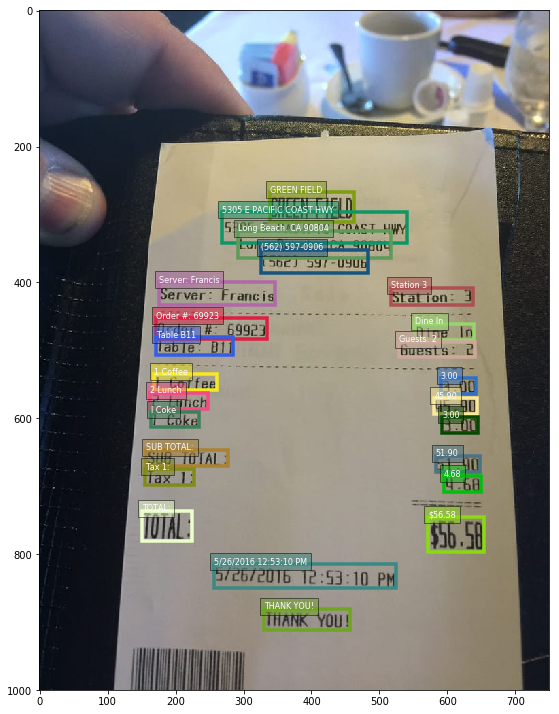

receipts_data/1000-receipt.jpg


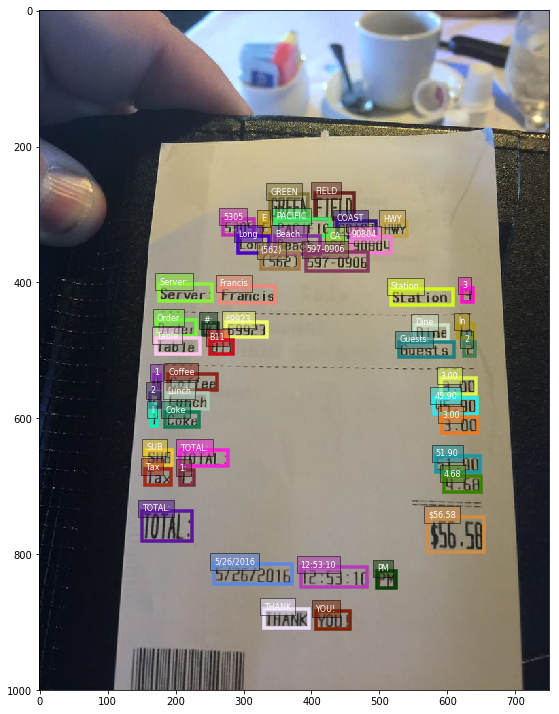

In [21]:
def analyse_bounding_boxex(configs, global_vars, records_enriched, bounding_type = 'LINE', max_entries_to_process=1):
    
    tmp_folder = configs['tmp_folder']
    s3 = global_vars['s3']
    cnt = 0
    for key,data in records_enriched.items():
        
        print(key)
        bounding_boxes = []
        local_path = tmp_folder + 'tmp.jpg'
        s3.Bucket(configs['bucket_name']).download_file(str(key), local_path)  
        response_raw = data['response_raw']['Blocks']
        for item in response_raw:
            if item["BlockType"] == bounding_type:
#                 print(item['Geometry'])
                word = item["Text"]
                x0 = item['Geometry']['BoundingBox']['Left']
                x1 = item['Geometry']['BoundingBox']['Left'] + item['Geometry']['BoundingBox']['Width']
                y0 = item['Geometry']['BoundingBox']['Top']
                y1 = item['Geometry']['BoundingBox']['Top'] + item['Geometry']['BoundingBox']['Height']

                bounding_boxes.append((x0, y0, x1, y1, word)) 
        
        utils.visualize_detection(local_path, bounding_boxes)
        cnt += 1
        if cnt >= max_entries_to_process:
            break
        
        
        
analyse_bounding_boxex(configs, global_vars, records_enriched, bounding_type = 'LINE', max_entries_to_process=1)
analyse_bounding_boxex(configs, global_vars, records_enriched, bounding_type = 'WORD', max_entries_to_process=1)



**Notes**: Using the bounding box information, we can start to do some more interesting work with the structure of the data, for instance, based on the spacing of the bounding boxes, and their relative coordinates with each other the other bounding boxes, we could start to examine the relationship between the tokens (e.g. 1, Coffee 3.00). This is clearly linked, however we would need to do some further processing to show this.

### 2.2 Basic Analysis of Enriched Results

One of the most basic steps we can do to understand the results of our OCR process, is to examine both the data at the Micro (e.g. at the level of each record), and at the Macro (e.g. the dataset as a whole). For each the Micro and Macro, we need to apply different instruments of analysis, and both will provide different insights to how we can use our data.

- Macro Level Analysis: This typically involves looking at distributions of records, from the type of tokens we have, measures of skewness, or depending on the domain of the dataset, aspects such as timeseries or PMD plots. For our domain, we will use this exploratory step to understand the type of tokens we're commonly identifying within our dataset, as well as the distribution of confidence scores across our words. This is going to be an iterative process, as what we're aiming to do here is refine our custom dictionary of words that we don’t want to include. Whilst it is hard to demonstrate how this iterative process happens, it's important to understand that the words in the ```stop_words_custom.txt``` file was not generated on a single pass, rather, it was an iterative process of viewing common words within the dataset, and based on the context of the data, we can keep or remove the words. A good example of this is the word `Server` or `Waiter`, for this domain (Receipt's data), this is going to be a common term, and for the purpose of our task, does not add value. That being said, if the task was to identify receipts where there was a `Server` or `Waiter` involved, then it would be beneficial to keep this term. 

In the ```analyse_records``` method below, a series of Macro level inspections on the data are conducted, such as examining the distribution of the confidence scores on the words across all the records, as well as the distribution of max values found, and spread of timestamps. Whilst these descriptive stats are quite rough and high-level, they provide some intuition on the processing pipeline we're building, and highlight any major flaws or errors in our steps. Using this visual inspection of the data, we can also refine the dictionary of stop words.


Total Non-unique Tokens 7755
Unique Tokens 4819
Top 10 Common Tokens ['0.00', 'chicken', '$0.00', '12.00', 'taco', 'coke', 'chees', 'grill', 'shrimp', 'dinner']
Highest Total Value 827.0 
Lowest Total Value 0.0 
Mean Total Value 67.59 
       max_values
count  200.000000
mean    67.592400
std    103.174735
min      0.000000
25%     18.825000
50%     38.545000
75%     73.265000
max    827.000000
Total Dates Found 211


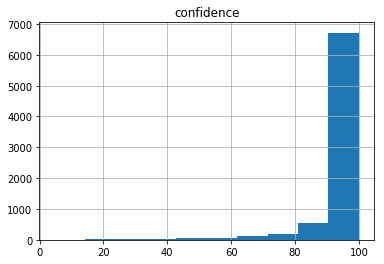

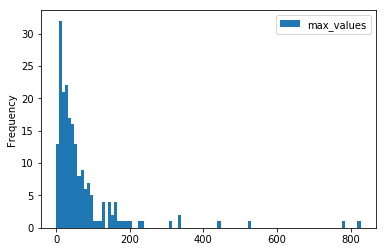

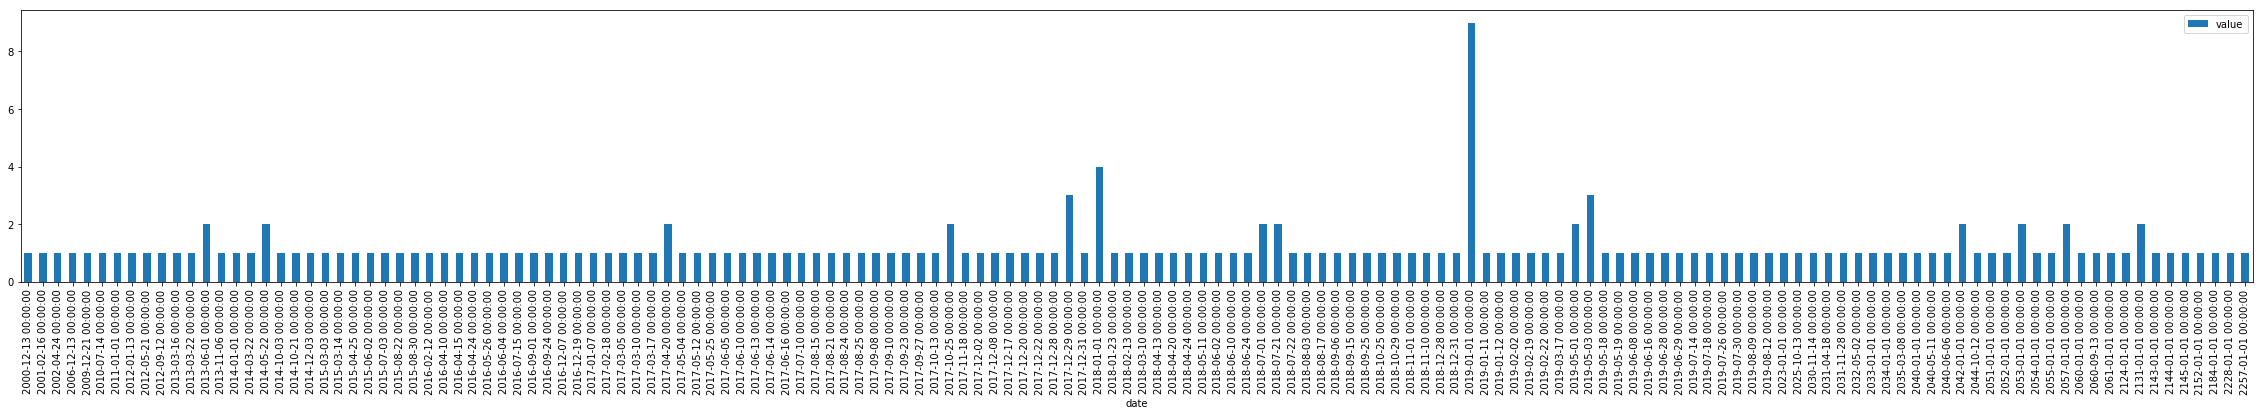

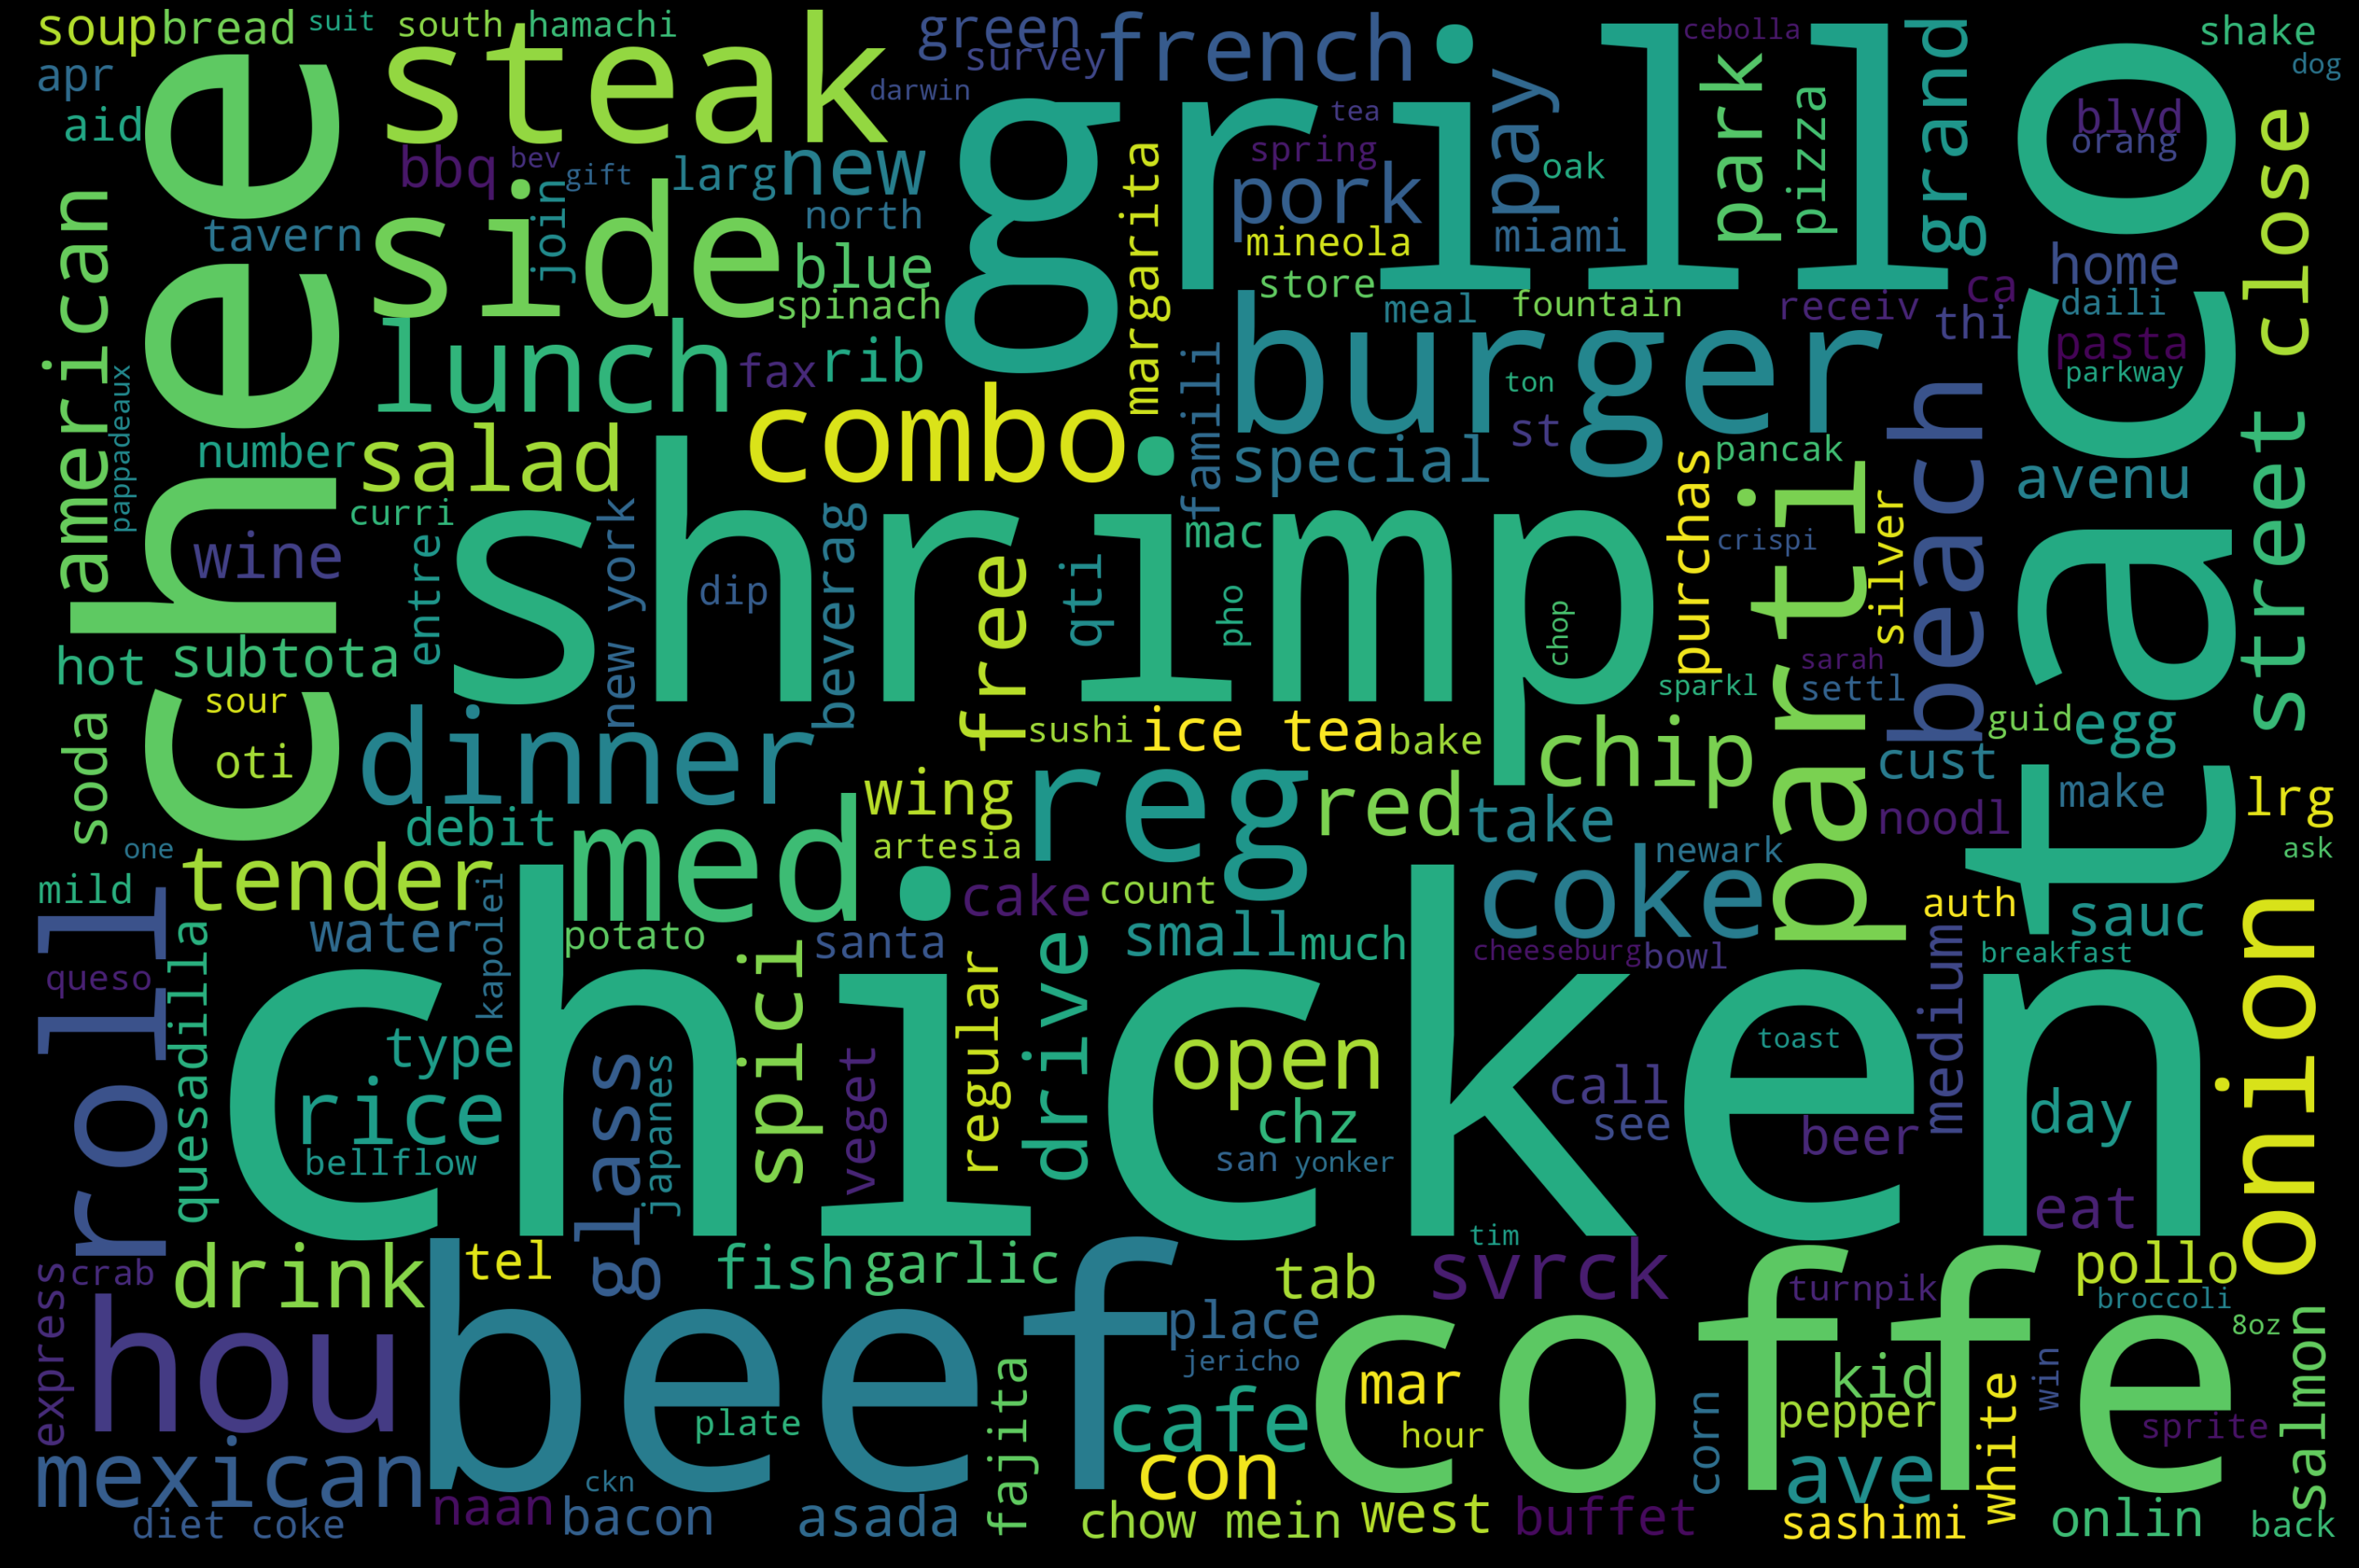

In [22]:
def analyse_records(records_enriched, word_cloud=False):
    

    words_conf = []
    dates = []
    values = []
    #raw data
    for key,data in records_enriched.items():
        
        words_conf = words_conf + data['word_confidences']
        dates = dates + data['dates']
        values.append(data['max_value'])
    
        
    #let's look at the distribution of confidence scores.    
    df_words = pd.DataFrame(words_conf)
    df_max_values = pd.DataFrame({'max_values':values})
    print('Total Non-unique Tokens {}'.format(df_words.shape[0]))
    
    print('Unique Tokens {}'.format(df_words['word'].unique().shape[0]))
    n = 10
    top_n_terms = df_words['word'].value_counts()[:n].index.tolist()
    print('Top {} Common Tokens {}'.format(n, top_n_terms))
    print('Highest Total Value {} '.format(max(df_max_values['max_values'])))
    print('Lowest Total Value {} '.format(min(df_max_values['max_values'])))
    print('Mean Total Value {} '.format(round(df_max_values['max_values'].mean(),2)))

    df_words.hist()
    df_max_values.plot.hist(bins=100)
    print(df_max_values.describe())
    words_list_non_unique = df_words['word'].tolist()
    
    #let's look at those dates
    print('Total Dates Found {}'.format(len(dates)))
    lowerbound_sanity_date = datetime.strptime('2000-01-01', '%Y-%m-%d')
    currentday = datetime.today().date()
    dates_cleaned = []
    for value in dates:
        date = pd.to_datetime(str(value))
        if (lowerbound_sanity_date < date):
            dates_cleaned.append(date)
            
    dates_df = pd.DataFrame({'date':dates_cleaned, 'value':1})
    dates_df.groupby('date').count().plot.bar(figsize=(40,5))
    #Simple word cloud to view our data.
    if word_cloud:
        string_of_words = ' '.join(map(str, words_list_non_unique)) 
        wordcloud = WordCloud(
            width = 3000,
            height = 2000,
            background_color = 'black',
            stopwords = STOPWORDS).generate(string_of_words)
        fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
        plt.imshow(wordcloud, interpolation = 'bilinear')
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.show()


    return df_words

df_words = analyse_records(records_enriched, word_cloud=True)

### 2.3 Token Co-Occurrence

In order to develop a richer understanding of the words within our receipts, we can calculate the co-occurrence of items within receipts, which can provide us further insight into the semantic similarity of our terms. For more information on Semantic Similarity, and Linguistic analysis, please check out these Wiki Entries: https://en.wikipedia.org/wiki/Semantic_similarity and https://en.wikipedia.org/wiki/Linguistics

For those who have worked in this space before, we can used TF-IDF techniques to calculate the co-occurrence, or libraries such as GloVe, which uses Vector Spaces of word representations in order to analyse the tokens. However, due to the nature of our data (each document has a small corpus of words), these methods can introduce interpretability challenges.

In ```token_coocurance``` we're going to start off with a very simple counter based approach, and look for co-occurence of ```n``` terms within a given receipt, and then count these across different receipts. 
 - E.g. if we see the terms **burger** and **fries** co-occur across multiple records, then we can infer that the receipts are showing that these two items are popular. It's important to remember that this method relies on raw counting, thus if we have common words such as **waiter** or **total** in our corpus, the results will be affected. Methods such as [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) and [LDA] (https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) help overcome these issues. 
 - For our method, we can provide the *combination_size* parameter, which is the number of tokens we want to generate the combinations for e.g. 2 -> (Term_A, Term_B), 3 -> (Term_A, Term_B, Term_C), and also the *min_cooc_cnt* which represnts the threshold in which to exclude terms from the returned dictionary of term co-occurrences.



In [339]:
def token_coocurence(records_enriched, combination_size = 2, min_cooc_cnt = 2):
    
    cooc_counts = {}
    for key,data in records_enriched.items():
        tokens = data['tokens']
        cleaned = [ x for x in tokens if (not x.isdigit()) and (len(x)> 2) and (not '.' in x) and (not '/' in x)]
        #remove dups
        cleaned =  list(dict.fromkeys(cleaned))
        cooc = list(combinations(cleaned, combination_size)) 
        for occ in cooc:
            if occ in cooc_counts:
                cnt = cooc_counts[occ]
                cooc_counts[occ] = cnt +1
            else:
                cooc_counts[occ] = 1
    print('Total Unique Token Co-Occurrences {}'.format(len(cooc_counts)))
    cooc_counts_sorted = dict( sorted(cooc_counts.items(), key=operator.itemgetter(1),reverse=True))
    top_k = 50
    cnt = 0
    cooc_counts_sorted_filtered = {key:val for key, val in cooc_counts_sorted.items() if val >= min_cooc_cnt}
    max_rows = 50
    idx = 0
    for k,v in cooc_counts_sorted_filtered.items():
        if idx < max_rows:
            print(k, v)
            idx += 1
    print('Filtered (min count {}) Unique Token Co-Occurrences {}'.format(min_cooc_cnt, len(cooc_counts_sorted_filtered)))
    return cooc_counts_sorted_filtered

cooc_counts_sorted_filtered = token_coocurence(records_enriched, combination_size = 2, min_cooc_cnt = 2)  

Total Unique Token Co-Occurrences 49491
('parti', 'svrck') 7
('ice', 'tea') 6
('chicken', 'rice') 5
('new', 'york') 5
('settl', 'tender') 4
('diet', 'coke') 4
('avenu', 'side') 4
('acct', 'auth') 4
('mexican', 'chicken') 4
('custom', 'copi') 4
('ave', 'chicken') 4
('chicken', 'beef') 4
('settl', 'creat') 3
('tender', 'creat') 3
('san', 'fernando') 3
('red', 'chicken') 3
('mexican', 'taco') 3
('cafe', 'open') 3
('mac', 'chz') 3
('chees', 'french') 3
('blvd', 'dinner') 3
('chicken', 'guid') 3
('buffet', 'weekend') 3
('buffet', 'dinner') 3
('sauc', 'chip') 3
('debit', 'aid') 3
('salad', 'day') 3
('cheeseburg', 'bacon') 3
('taco', 'asada') 3
('jericho', 'park') 3
('hous', 'wine') 3
('beach', 'cust') 3
('tel', 'cust') 3
('cust', 'chees') 3
('brussel', 'sprout') 3
('wing', 'thing') 3
('wing', 'mac') 3
('wing', 'small') 3
('lafourc', 'alain') 3
('lafourc', 'char') 3
('lafourc', 'eari') 3
('lafourc', 'calss') 3
('lafourc', '02-00-2015') 3
('lafourc', 'note') 3
('lafourc', 'penrter') 3
('lafour

**Notes:** From this data, we could start to build some very primitive (and naive) predictive model, which would state. We can see there are some common words that appear to repeat in several of the receipts in our model..

We have already gained some insight into what our data looks like in terms of raw text, as well as distribution of terms:

- We know the confidence is on average, high for predicted words
- we know that there is a skewed distribution of total bill costs
- we know that certain items are more popular than others

One of the first things we can do is explore the relationship between the type of food in a receipt, and the overall cost.


### 2.4 Feature Analysis using Co-Occurrence

In order to perform feature analysis, we need to transform our data using One-Hot-Encoding, which essentially means transposing the data where the tokens become columns, and the values for the columns represent whether the row (receipt) has that value or not. If you're familar with TF-IDF, this step is similar with constructing the Term Frequency table, however, for our example, we're not going to take into consideration the counts of words (.e.g if Coffee appears twice), but just if the term exists or not. 

For instance, we may have a receipt which contains:

- Coffee 
- Toast
- Cake

And in the current data this looks like:

```row{'tokens': ['coffee','toast','cake']}```

However what we want to have is a dataframe (or dict), which looks like 

```row{'coffee':1, 'toast':1, 'cake':1}```

And when we do this for every row, we're going to end up with a LOT of columns (which will be equal to the number of unique tokens we have), thus we need some way to reduce this down, which can either be done by using techniques such as Principle Component Analysis (PCA), or we can do something more simple, such as use our word co-occurrence data, and filter by tokens which are within this list, plus, reduce columns where a Percentage of the columns are 0 (e.g. not present in the receipt).



Total Unqiue words to match against 374
Removing Columns which are all 0 in this group
high_cost (58, 262)
Removed 114 Columns
Columns where 0.05 pct of rows all have values
Remaining Columns ['asparagu', 'ave', 'avenu', 'beach', 'beef', 'blue', 'blvd', 'brussel', 'burger', 'cab', 'cake', 'chicken', 'chip', 'chop', 'coffe', 'coke', 'custom', 'diet', 'dinner', 'express', 'famili', 'filename', 'fish', 'garlic', 'glass', 'grand', 'grill', 'hous', 'jericho', 'label', 'margarita', 'med', 'mexican', 'new', 'onion', 'onlin', 'open', 'park', 'parti', 'pork', 'qti', 'quesadilla', 'red', 'reg', 'rib', 'rice', 'salad', 'salmon', 'see', 'shrimp', 'side', 'sirloin', 'steak', 'street', 'tea', 'top', 'west', 'white', 'wine', 'york']
Shape of Data Remaining (58, 60)




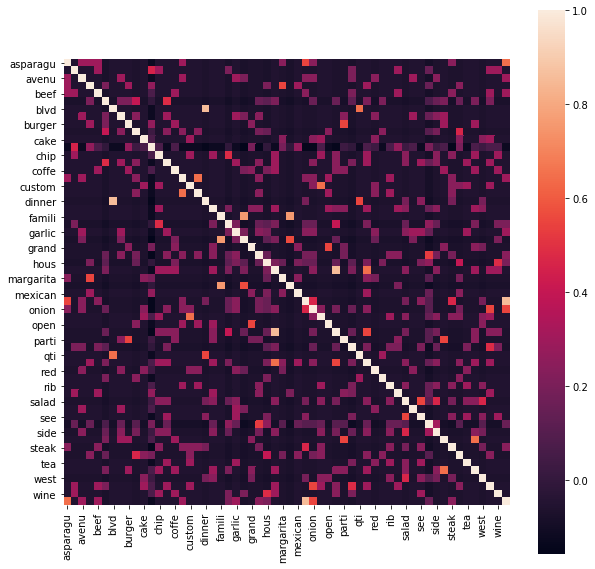

Removing Columns which are all 0 in this group
low_cost (84, 276)
Removed 100 Columns
Columns where 0.05 pct of rows all have values
Remaining Columns ['acct', 'american', 'auth', 'beef', 'cafe', 'chees', 'chicken', 'chip', 'close', 'coffe', 'coke', 'drink', 'drive', 'egg', 'filename', 'free', 'french', 'hot', 'label', 'lunch', 'pay', 'purchas', 'roll', 'street', 'taco', 'take', 'tender', 'type', 'wing']
Shape of Data Remaining (84, 29)




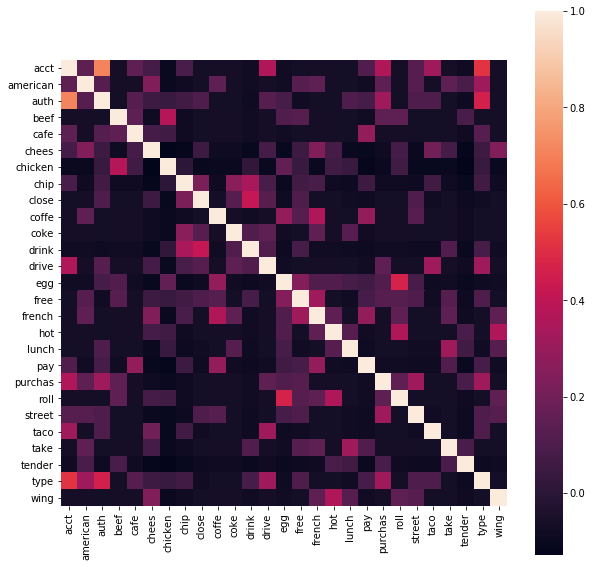

Removing Columns which are all 0 in this group
medium_cost (58, 261)
Removed 115 Columns
Columns where 0.05 pct of rows all have values
Remaining Columns ['ave', 'avenu', 'bacon', 'bbq', 'beach', 'beef', 'bread', 'burger', 'cafe', 'cake', 'chees', 'cheeseburg', 'chicken', 'chz', 'close', 'coffe', 'coke', 'combo', 'crab', 'cust', 'day', 'dinner', 'drive', 'fajita', 'filename', 'free', 'french', 'garlic', 'glass', 'grill', 'hamburg', 'hous', 'label', 'larg', 'lunch', 'mac', 'medium', 'mexican', 'new', 'onion', 'open', 'parti', 'pepper', 'pollo', 'ranch', 'red', 'reg', 'rice', 'salad', 'sarah', 'seafood', 'shrimp', 'side', 'small', 'soda', 'soup', 'special', 'spinach', 'steak', 'svrck', 'taco', 'take', 'tea', 'tel', 'tender', 'water', 'well', 'west', 'wing', 'www']
Shape of Data Remaining (58, 70)




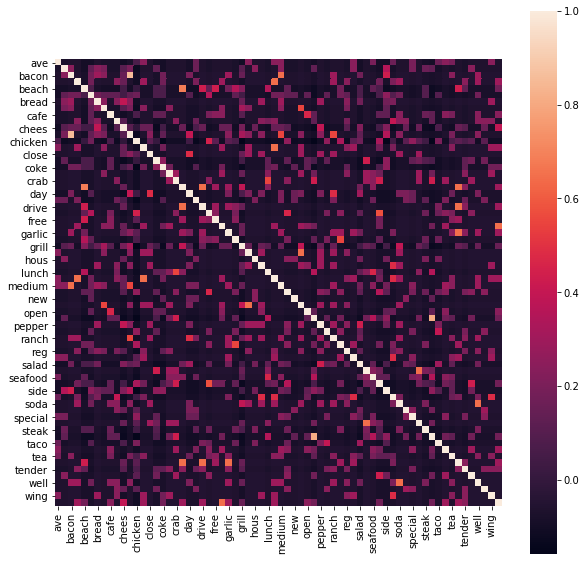

Final Feature Engineered DF (200, 110)


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:84: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [387]:
%matplotlib inline

def cost_type(x):
        lower = 0
        lower_thres = 30
        mid_thresh = 67
        
        if x >= lower and x < lower_thres:
            return 'low_cost'
        if x > lower_thres and x < mid_thresh:
            return 'medium_cost'
        if x > mid_thresh:
            return 'high_cost'
        
def food_cost_analysis(records_enriched, cooc_counts_sorted_filtered, pct_not_empty = 0.1):
    
    '''lets use some buckets to group our bills total value
        mean    67.59240
        min      0.000000
        25%     18.825000
        50%     38.545000
        75%     73.265000
    '''
    unique_words_cooc = set()
    for k,v in cooc_counts_sorted_filtered.items():
        unique_words_cooc.add(k[0])
        unique_words_cooc.add(k[1])
        
    print('Total Unqiue words to match against {}'.format(len(unique_words_cooc)))
    words_conf = []
    values = []
    #raw data
    rows = []
    dfs_grouped = {}
    for key,data in records_enriched.items():
        
        tmp = {}
        #think one hot encoding
        for token in data['tokens']:
            if (token in unique_words_cooc) and (not token.isdigit()) and (len(token) > 2):
                
                tmp[token] = 1
        
        cost_type_lab = cost_type(data['max_value'])
        tmp['label'] = cost_type_lab
        tmp['filename'] = key
        rows.append(tmp)
#         break

    df_features = pd.DataFrame(rows)
    df_features = df_features.fillna(0)
    df_features = df_features[df_features['label'] !=0]
    columns = list(df_features.columns)
    
    #now let's group by label type
    feature_eng_data = []
    for name,group in df_features.groupby('label'):
        cleaned_group =  group.loc[(group).any(1), (group!=0).any(0)]
        print('Removing Columns which are all 0 in this group')
        print(name, cleaned_group.shape)
        cols = list(cleaned_group.columns)
        cut_cols  = list(set(columns) - set(cols))
        print('Removed {} Columns'.format(len(cut_cols)))
        
        tmp = group.replace([0,' ','NULL'],np.nan)
        common_feats = tmp.dropna(thresh=tmp.shape[0]*pct_not_empty,how='all',axis=1) 
        common_feats = common_feats.fillna(0)

        print('Columns where {} pct of rows all have values'.format(pct_not_empty))
        print('Remaining Columns {}'.format(list(common_feats.columns)))
        print('Shape of Data Remaining {}'.format(common_feats.shape))
        print('\n')
        dfs_grouped[cost_type_lab] = common_feats
        
        corrs = common_feats.corr()
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(corrs, square=True)
        plt.show()
        feature_eng_data.append(common_feats)

    #add all feature dfs together
    feat_eng_df = pd.concat(feature_eng_data)
    feat_eng_df = feat_eng_df.fillna(0)

    print('Final Feature Engineered DF {}'.format(feat_eng_df.shape))
    return feat_eng_df
feat_eng_df = food_cost_analysis(records_enriched,cooc_counts_sorted_filtered, pct_not_empty=0.05)           

**Notes:** From the analysis, we can see that depending on the cost of the bill (which has be set based on the distribution of receipt max_values that we initially analysed), the type and number of items within buckets (low, medium, high), changes.

Adjusting the pct_not_empty to a smaller value, and also increasing the size of the word co-occurrence list will increase the number of columns within the datasets, however, this may not have a positive impact on understanding the feature space, given that this brute force approach is trying to identify features which have importance on the bill cost.


### 2.5 Word Embeddings 

Another approach is to examine the word embeddings of the text in order to determine relationships between the terms (tokens) within the data.

Word2Vec is a popular algorithm used for generating dense vector representations of words in large corpora using unsupervised learning. The resulting vectors have been shown to capture semantic relationships between the corresponding words and are used extensively for many downstream natural language processing (NLP) tasks like sentiment analysis, named entity recognition and machine translation.

In order to achieve this, we're going to be using SageMaker's ```blazingtext``` estimator.



In [169]:
def prep_data_form_sagemaker_training(configs, global_vars, records_enriched):
    
    tokens = []
    #raw data
    for key,data in records_enriched.items():
        
#         print(data['max_value'])
        tokens = tokens + data['tokens']
    
    cleaned = [ x for x in tokens if (not x.isdigit()) and (len(x)> 2) ]

    corpus = ' '.join(map(str, cleaned)) 
    print('Total Corpus Size: {} Tokens'.format(len(tokens)))
    print('Total Char Size: {} '.format(len(corpus)))
    
    return corpus
    
    
corpus = prep_data_form_sagemaker_training(configs, global_vars, records_enriched)    

Total Corpus Size: 8956 Tokens
Total Char Size: 44707 


In [170]:
def upload_corpus_to_s3(configs, global_vars, corpus):
    
    dataset_key = 'train'
    s3_bucket = global_vars['s3_bucket']
    
    sess = global_vars['sess']
    bucket = global_vars['s3_bucket']
    
    with open(dataset_key, 'w') as f:
        f.write(corpus)
   
        
    data_file_s3 = configs['training_data_prefix_s3'] + dataset_key
    s3_bucket.upload_file(dataset_key, data_file_s3)   

    s3_train_data = 's3://{}/{}'.format(configs['bucket_name'], configs['training_data_prefix_s3'])
    s3_output_location = 's3://{}/output'.format(configs['bucket_name'])
    configs['s3_train_data'] = s3_train_data
    configs['s3_output_location'] = s3_output_location

    print('S3 Training Data Path {}'.format(s3_train_data))
    print('S3 Training Data Path {}'.format(s3_output_location))

    return configs
configs = upload_corpus_to_s3(configs, global_vars, corpus) 

S3 Training Data Path s3://aws-demo-receipts/training_data/
S3 Training Data Path s3://aws-demo-receipts/output


In [171]:
def configure_estimator(configs, global_vars):
    
    region_name = configs['aws_region'] 
    sess = global_vars['sess']
    container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
    print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

    bt_model = sagemaker.estimator.Estimator(container,
                                         global_vars['role'], 
                                         train_instance_count=2, 
                                         train_instance_type='ml.c4.2xlarge',
                                         train_volume_size = 5,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=configs['s3_output_location'],
                                         sagemaker_session=sess)
    
    bt_model.set_hyperparameters(mode="batch_skipgram",
                             epochs=5,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=5,
                             vector_dim=100,
                             negative_samples=5,
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=True,# Perform similarity evaluation on WS-353 dataset at the end of training
                             subwords=False) # Subword embedding learning is not supported by batch_skipgram
    
    train_data = sagemaker.session.s3_input(configs['s3_train_data'], distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

    data_channels = {'train': train_data}
    
   
    global_vars['train_data'] = train_data
    global_vars['data_channels'] = data_channels
    global_vars['bt_model'] = bt_model
    
    return global_vars

global_vars = configure_estimator(configs, global_vars)

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


In [ ]:
def fit_model(configs, global_vars):
    
    bt_model = global_vars['bt_model']
    data_channels = global_vars['data_channels']
    bt_model.fit(inputs=data_channels, logs=True)
    
    
fit_model(configs, global_vars)

2020-03-18 08:36:38 Starting - Starting the training job...
2020-03-18 08:36:42 Starting - Launching requested ML instances......
2020-03-18 08:37:45 Starting - Preparing the instances for training...
2020-03-18 08:38:37 Downloading - Downloading input data......
2020-03-18 08:39:23 Training - Training image download completed. Training in progress.Arguments: train
Arguments: train
Found 10.2.182.94 for host algo-1
Found 10.2.129.203 for host algo-2
Found 10.2.182.94 for host algo-1
Found 10.2.129.203 for host algo-2
[03/18/2020 08:39:37 WARNING 140172897224512] Loggers have already been setup.
[03/18/2020 08:39:37 WARNING 140172897224512] Loggers have already been setup.
[03/18/2020 08:39:37 INFO 140172897224512] nvidia-smi took: 0.0251920223236 secs to identify 0 gpus
[03/18/2020 08:39:37 INFO 140172897224512] Running distributed CPU BlazingText training using batch_skipgram on 2 hosts.
[03/18/2020 08:39:37 INFO 140172897224512] Number of hosts: 2, master IP address: 10.2.182.94, hos

#### 2.5.1 Evaluate Word Embedding Results

In the following section we will download the model results which have been saved to the S3 bucket at the location we have defined in our `configs`, then using this data we will explore the word embeddings using t-distributed Stochastic Neighbor Embedding (tSNE), which is a tool to be able to visualize high-dimensional data.

In [175]:
def download_model_results(configs, global_vars):
    
    bt_model = global_vars['bt_model']
    s3 = global_vars['s3']
    bucket_name = configs['bucket_name']
    model_filename = 'model.tar.gz'
    key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
    s3.Bucket(bucket_name).download_file(key, model_filename )

    #untar file
    tar = tarfile.open(model_filename)
    tar.extractall()
    tar.close()

download_model_results(configs, global_vars)


In [43]:
def evaluate_model_results():
    
    #cheapest way to find maximum number of vectors to generate our TSNE representations
    cnt  = 0
    with open("vectors.txt","r") as f:
        for line in f:
            cnt +=1
    print('Total Vector Space {}'.format(cnt))
    num_points = cnt


    first_line = True
    index_to_word = []
    with open("vectors.txt","r") as f:
        for line_num, line in enumerate(f):
            if first_line:
                dim = int(line.strip().split()[1])
                word_vecs = np.zeros((num_points, dim), dtype=float)
                first_line = False
                continue
            line = line.strip()
            word = line.split()[0]
            vec = word_vecs[line_num-1]
            for index, vec_val in enumerate(line.split()[1:]):
                vec[index] = float(vec_val)
            index_to_word.append(word)
            if line_num >= num_points:
                break
    word_vecs = normalize(word_vecs, copy=False, return_norm=False)

    tsne = TSNE(perplexity=4, n_components=2, init='pca', n_iter=10000, verbose=1)
    two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
    labels = index_to_word[:num_points]
    
    print('Total Tokens {}'.format(len(labels)))
    
    return two_d_embeddings, labels

two_d_embeddings, labels = evaluate_model_results()

Total Vector Space 235
[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 235 samples in 0.001s...
[t-SNE] Computed neighbors for 235 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 235 / 235
[t-SNE] Mean sigma: 0.188671
[t-SNE] KL divergence after 250 iterations with early exaggeration: 184.362259
[t-SNE] KL divergence after 10000 iterations: 2.901935
Total Tokens 234


#### Plotting Embeddings
 t-SNE and Word2Vec are stochastic, so although when you run the code the plot won’t look the same everytime the methods are executed

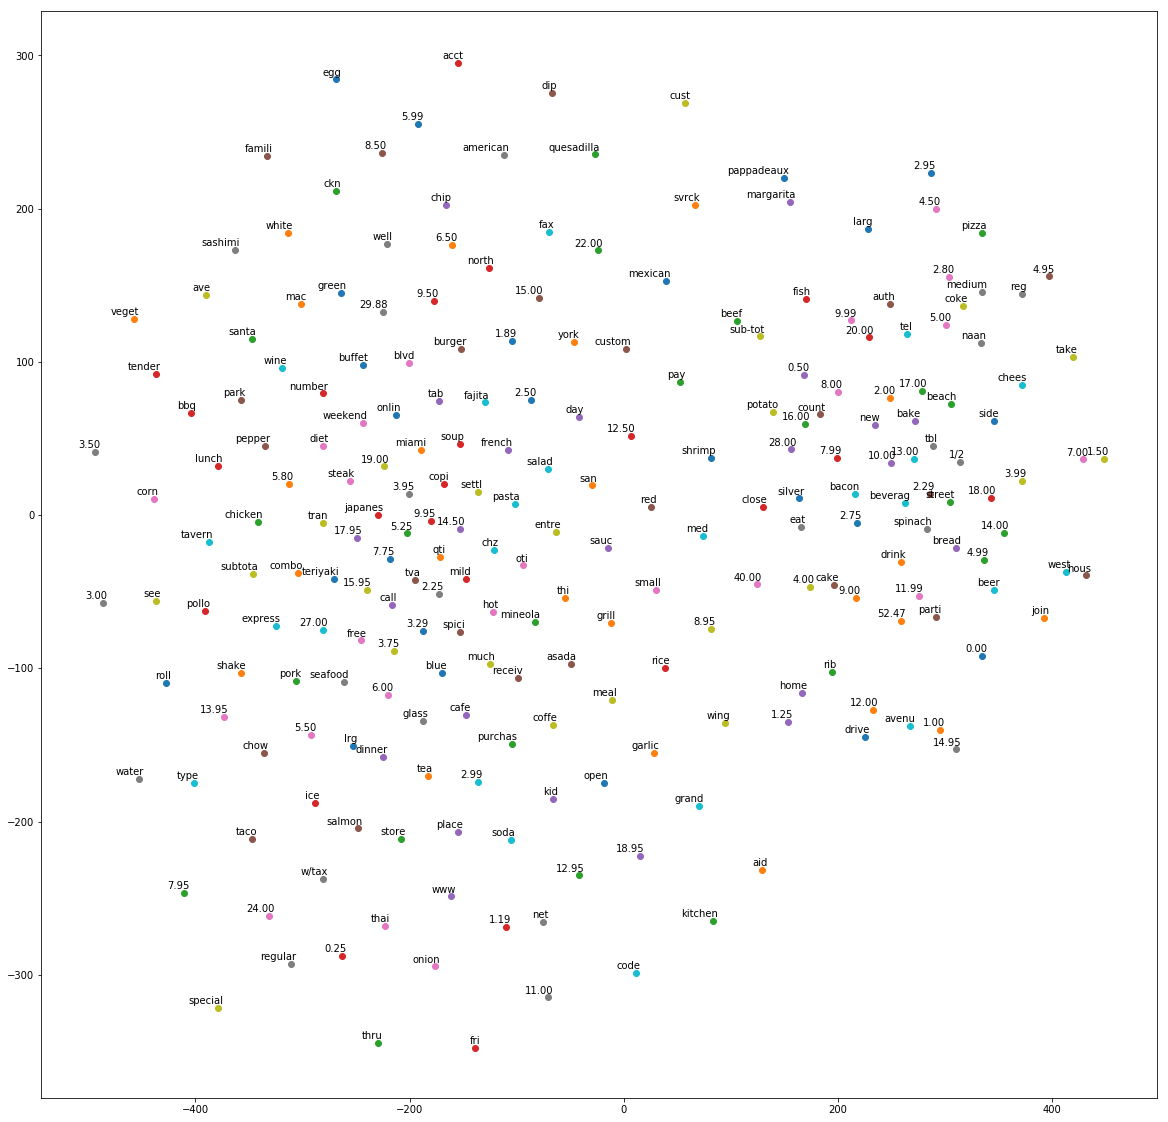

In [44]:
def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embeddings, labels)

Notes: Compared to the Word Co-Occurence Approach, work embeddings usign Skip-Grams provide an abstraction of tokens within a given vector space, which allows for relationships between different words to be exposed! We can see from the results, we are seeing words such as Pasta, Pizza, and Cheese occuring within the same vector space, for instance. Pretty good considering the tokens used to build our embeddings was extremely small!


## Part 3. Export Processed Data

Once we've performed all our analysis and decided what data we want to use and how we want it structured, we'll to take this data which resides in dataframes, txt files, and save it either to an S3 Bucket, or perhaps to a Database to be consumed by another service.


### Part 3.1 - Export to Amazon S3

In this section, we're going to take the processed/enriched datasets and save them to S3 for ingestion into a DB.

In [389]:
def export_enriched_data_to_s3(configs, global_vars, records_enriched):
    
    s3 = global_vars['s3']
    bucket_name = configs['bucket_name']
    for key,record in records_enriched.items():
        filename = key.replace(configs['dataset_path_s3'],'').replace('.jpg','.json')
        s3_file_path = configs['output_data_s3'] + filename
        s3object = s3.Object(bucket_name, s3_file_path)
        s3object.put(
            Body=(bytes(json.dumps(record).encode('UTF-8')))
        )
        
export_enriched_data_to_s3(configs, global_vars, records_enriched)          

In [388]:
def export_feature_engineered_data_to_s3(configs, global_vars, feat_eng_df):

    s3 = global_vars['s3']
    bucket_name = configs['bucket_name']
    data = feat_eng_df.to_csv(index=False)
    filename = 'dataset_features.csv'
    s3_file_path = configs['output_data_s3'] + filename
    s3object = s3.Object(bucket_name, s3_file_path)
    s3object.put(
        Body=(bytes(data.encode('UTF-8')))
    )
        
export_feature_engineered_data_to_s3(configs, global_vars, feat_eng_df) 

### End of Notebook

If you have any feedback or questions, please reach out at tramine AT amazon DOT com